# Preprocessing, GridSearch and Training F-DenseNet-8 on Private Data

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression

import gc
import os

#from sklearn.externals import joblib
import joblib

from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import stratified_split
from Filter_and_Grid_Search import attributes_list, attributes_list_new
from Filter_and_Grid_Search import get_s_stat, get_PSI_stat, get_stats_by_month, get_stats, stable_unstable
from Filter_and_Grid_Search import stable_unstable_by_month_divide, union_datas, individual_hists_all 
from Filter_and_Grid_Search import paired_time_hists_by_month, statistics_with_target
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import statistics_with_target, attributes_list, attributes_list_new, make_standard
from Filter_and_Grid_Search import data_preprocessing_train, data_preprocessing_test
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import stratified_split, two_forests, turn_variables_with_values
from Filter_and_Grid_Search import find_meta_params, calculate_vif#, find_meta_params_mem
from Filter_and_Grid_Search import plot_meta_2d, data_preprocessing, find_ouliers_iqr
from Filter_and_Grid_Search import train_model_receive_stats, simple_b_score_risk
from Filter_and_Grid_Search import max_prof_corve, by_month_gini, check_attribute_list_cases

from Filter_and_Grid_Search import to_zip, br_correction, br_stat

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading data

In [2]:
PATH_DATA = 'D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/'
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/'
print(PATH_DATA)
print(PATH)

D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/
D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/


In [3]:
for DIR in ['Data Sets', 'Documentation', 'Graphs', 'Modeling', 'SandBox', 'Selection', 'Statistics']:
    PATH_DIR = PATH + DIR
    print(PATH_DIR)
    pathlib.Path(PATH_DIR).mkdir(parents=True, exist_ok=True)
    
for DIR in ['csv_from_python', 'excel', 'python']:
    PATH_DIR = PATH + 'Selection/' + DIR
    print(PATH_DIR)
    pathlib.Path(PATH_DIR).mkdir(parents=True, exist_ok=True) 

D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Data Sets
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Documentation
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Graphs
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Modeling
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/SandBox
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Selection
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Statistics
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Selection/csv_from_python
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Selection/excel
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/Selection/python


In [3]:
#Сырые данные
train_data = 'antifraud_data_train_with_2014.csv'
test_data  = 'antifraud_data_test_with_2014.csv'
val_data   = 'antifraud_data_valid_with_2014.csv'

In [4]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [5]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [6]:
COL_DEL

['UNNAMED: 0', 'PERIOD_7', 'LOSS_90P']

In [7]:
necessary_fields

['BAD_FLAG', 'MONTH_YEAR', 'APPPOSID']

In [8]:
n_jobs = 3

In [9]:
path_train_data = PATH_DATA  +  train_data

## Features selection

In [12]:
data = pd.read_csv(path_train_data, sep = '&', encoding = 'cp1251'
                   #, index_col = 0
                   , nrows = 0
                  )
data_columns = data.columns

In [13]:
path_train_data

'D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/antifraud_data_train_with_2014.csv'

In [221]:
for k in data_columns:
    print(k)

Unnamed: 0
APPPOSID
PERIOD_7
SUB_CHANNEL
COUNT_APP_7
COUNT_CONT_7
COUNT_APP_14
COUNT_CONT_14
COUNT_APP_30
COUNT_CONT_30
COUNT_APP_60
COUNT_CONT_60
DIVISION
B_TEST_AGE_3_7D
B_TEST_AGE_3_14D
B_TEST_AGE_3_30D
B_TEST_AGE_3_60D
W_TEST_AGE_3_7D
W_TEST_AGE_3_14D
W_TEST_AGE_3_30D
W_TEST_AGE_3_60D
B_TEST_AGE_6_7D
B_TEST_AGE_6_14D
B_TEST_AGE_6_30D
B_TEST_AGE_6_60D
W_TEST_AGE_6_7D
W_TEST_AGE_6_14D
W_TEST_AGE_6_30D
W_TEST_AGE_6_60D
B_TEST_AGE_10_7D
B_TEST_AGE_10_14D
B_TEST_AGE_10_30D
B_TEST_AGE_10_60D
W_TEST_AGE_10_7D
W_TEST_AGE_10_14D
W_TEST_AGE_10_30D
W_TEST_AGE_10_60D
B_TEST_AGE_ALL5_7D
B_TEST_AGE_ALL5_14D
B_TEST_AGE_ALL5_30D
B_TEST_AGE_ALL5_60D
W_TEST_AGE_ALL5_7D
W_TEST_AGE_ALL5_14D
W_TEST_AGE_ALL5_30D
W_TEST_AGE_ALL5_60D
B_TEST_PASP_D_3_7D
B_TEST_PASP_D_3_14D
B_TEST_PASP_D_3_30D
B_TEST_PASP_D_3_60D
B_TEST_PASP_D_6_7D
B_TEST_PASP_D_6_14D
B_TEST_PASP_D_6_30D
B_TEST_PASP_D_6_60D
B_TEST_PASP_D_10_7D
B_TEST_PASP_D_10_14D
B_TEST_PASP_D_10_30D
B_TEST_PASP_D_10_60D
B_TEST_PASP_D_ALL5_7D
B_TEST_PASP_D

In [14]:
type_cols = {c:'int' for c in necessary_fields}
type_cols

{'BAD_FLAG': 'int', 'MONTH_YEAR': 'int', 'APPPOSID': 'int'}

In [27]:
col_out = ['APPPOSID', 'PERIOD_7', 'SUB_CHANNEL', 'COUNT_APP_7', 'DIVISION', 'MONTH_YEAR', 'BAD_FLAG',
          'COUNT_APP_7' , 'COUNT_CONT_7' , 'COUNT_APP_14' , 'COUNT_CONT_14' , 'COUNT_APP_30' , 'COUNT_CONT_30',
           'COUNT_APP_60', 'COUNT_CONT_60']

In [28]:
data_1 = pd.read_csv(path_train_data, sep = '&', encoding = 'utf-8' #'cp1251'
                   #, index_col = 0
                   , usecols = [c for c in col_out]
 #                  , dtype={c:type_cols.get(c.upper(),'float32') for c in data_columns}
                 # , nrows = 100000
                  )

In [30]:
data_1.head()

,APPPOSID,PERIOD_7,SUB_CHANNEL,COUNT_APP_7,COUNT_CONT_7,COUNT_APP_14,COUNT_CONT_14,COUNT_APP_30,COUNT_CONT_30,COUNT_APP_60,COUNT_CONT_60,DIVISION,MONTH_YEAR,BAD_FLAG
0,3175,124,LOCALS_OFFLINE,7,3,9,5,12,5,24,11,Приволжский,201710,0
1,3175,125,LOCALS_OFFLINE,2,2,3,2,9,4,19,10,Приволжский,201710,0
2,3175,126,LOCALS_OFFLINE,1,0,3,0,11,3,20,9,Приволжский,201710,0
3,3175,127,LOCALS_OFFLINE,2,0,4,0,10,3,22,11,Приволжский,201709,0
4,3175,128,LOCALS_OFFLINE,2,0,7,2,12,6,22,12,Приволжский,201709,0


In [31]:
data_1.to_csv(PATH + 'train_cut_aug.csv')

In [228]:
data = pd.read_csv(path_train_data, sep = '&', encoding = 'utf-8' #'cp1251'
                   #, index_col = 0
                   , usecols = [c for c in data_columns if c.upper() not in COL_DEL]
 #                  , dtype={c:type_cols.get(c.upper(),'float32') for c in data_columns}
                 # , nrows = 100000
                  )
data.columns = [col.upper() for col in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507599 entries, 0 to 1507598
Columns: 509 entries, APPPOSID to BAD_FLAG
dtypes: float64(420), int64(87), object(2)
memory usage: 5.7+ GB


In [229]:
data.head()

,APPPOSID,SUB_CHANNEL,COUNT_APP_7,COUNT_CONT_7,COUNT_APP_14,COUNT_CONT_14,COUNT_APP_30,COUNT_CONT_30,COUNT_APP_60,COUNT_CONT_60,...,COUNT_INC_30,RULE_DIFF_INC_3_30,RULE_DIFF_INC_7_30,RULE_DIFF_INC_9_30,COUNT_INC_60,RULE_DIFF_INC_3_60,RULE_DIFF_INC_7_60,RULE_DIFF_INC_9_60,MONTH_YEAR,BAD_FLAG
0,3175,LOCALS_OFFLINE,7,3,9,5,12,5,24,11,...,12,0.0,0.0,0.0,24,0.0,0.0,0.0,201710,0
1,3175,LOCALS_OFFLINE,2,2,3,2,9,4,19,10,...,9,0.0,0.0,0.0,19,0.0,0.0,0.0,201710,0
2,3175,LOCALS_OFFLINE,1,0,3,0,11,3,20,9,...,11,0.0,0.0,0.0,20,0.0,0.0,0.0,201710,0
3,3175,LOCALS_OFFLINE,2,0,4,0,10,3,22,11,...,10,0.0,0.0,0.0,22,0.0,0.0,0.0,201709,0
4,3175,LOCALS_OFFLINE,2,0,7,2,12,6,22,12,...,12,0.0,0.0,0.0,22,0.0,0.0,0.0,201709,0


In [230]:
for c in data.columns:
    if data[c].dtype not in ['float32', 'int64', 'float64']:
        print(c, data[c].dtype)

SUB_CHANNEL object
DIVISION object


In [231]:
columns = [ c for c in data.columns if c not in COL_DEL + necessary_fields]

In [232]:
attribute_list = attributes_list_new(data, columns, [0.01, 0.5, 1, 2, 5, 95, 98, 99, 99.5, 99.99])

[1.000e-04 5.000e-03 1.000e-02 2.000e-02 5.000e-02 9.500e-01 9.800e-01
 9.900e-01 9.950e-01 9.999e-01]
Number of finished repetitions: 0 | time:  09.09.2020 15:06:33
Number of finished repetitions: 100 | time:  09.09.2020 15:07:53
Number of finished repetitions: 200 | time:  09.09.2020 15:09:16
Number of finished repetitions: 300 | time:  09.09.2020 15:10:10
Number of finished repetitions: 400 | time:  09.09.2020 15:10:43
Number of finished repetitions: 500 | time:  09.09.2020 15:11:17


In [233]:
#Необходимо проанализировать полученные списки переменных

# Рекомендовано удалить:

#бессмысленные переменные, нет заполненных значений
attribute_list_all_misses = attribute_list[(attribute_list['count_miss'] == data.shape[0])]

#СЛИШКОМ много бинов, подозрение на ID
attribute_list_object_many_distinct =  attribute_list[(attribute_list['count_dist'] >= 150)
                                        & (attribute_list['type_val']!= 'float32')
                                        & (attribute_list['type_val']!= 'float64')] # == 'int')]

#Более 95% пропущено
attribute_list_many_misses = attribute_list[(attribute_list['count_miss'] >= data.shape[0]*0.97)
                                          & (attribute_list['count_miss'] != data.shape[0])]

#Слишком много уникальных значений, подозрение на ID
attribute_list_all_distinct = attribute_list[(attribute_list['count_dist'] >= data.shape[0]*0.95)] 

#Переменная имеет всего одно значение:
attribute_list_сonst =  attribute_list[(attribute_list['count_dist'] == 1) & (attribute_list['count_miss'] == 0)]

#Переменная имеет всего одно значение остальные могут быть пустые:
attribute_list_one_value = attribute_list[(attribute_list['count_dist'] == 1) & (attribute_list['count_miss'] != 0)]

#Первый персентиль равен 99
attribute_list_1_eq_99 =attribute_list[(attribute_list['1%'] == attribute_list['99%'])]

In [234]:
attribute_list_all_misses

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,unique,top,freq,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [235]:
attribute_list_object_many_distinct

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,unique,top,freq,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val
1,COUNT_APP_7,int64,478,0,4.0,92958,1.5076e+06,NaN,NaN,NaN,...,1,1,2,10,52,79,101,126,359,1315
2,COUNT_CONT_7,int64,156,0,0.0,449612,1.5076e+06,NaN,NaN,NaN,...,0,0,0,1,11,18,25,33,95.2402,224
3,COUNT_APP_14,int64,730,0,7.0,55488,1.5076e+06,NaN,NaN,NaN,...,2,3,4,19,94,143,185,229,631.24,2134
4,COUNT_CONT_14,int64,248,0,0.0,262144,1.5076e+06,NaN,NaN,NaN,...,0,0,0,3,19,32,45,59,170.24,333
5,COUNT_APP_30,int64,1205,0,7.0,31323,1.5076e+06,NaN,NaN,NaN,...,7,7,9,40,190,290,375,463,1202.48,3973
6,COUNT_CONT_30,int64,430,0,2.0,145271,1.5076e+06,NaN,NaN,NaN,...,0,0,0,5,38,64,89,117,336,681
7,COUNT_APP_60,int64,1952,0,21.0,13876,1.5076e+06,NaN,NaN,NaN,...,9,11,15,75,362,553,712,880,2114.48,7255
8,COUNT_CONT_60,int64,728,0,4.0,86736,1.5076e+06,NaN,NaN,NaN,...,0,0,1,10,70,121,166,219,639,1260
212,COUNT_H_TT_7,int64,338,0,3.0,133946,1.5076e+06,NaN,NaN,NaN,...,0,0,1,7,35,55,71,89,236.24,692
218,COUNT_H_TT_14,int64,529,0,5.0,79942,1.5076e+06,NaN,NaN,NaN,...,1,2,3,13,63,100,129,161,416.24,1157


In [236]:
attribute_list_all_distinct

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,unique,top,freq,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val
16,W_TEST_AGE_3_30D,float64,1463569,0,0.0,3837,1.5076e+06,NaN,NaN,NaN,...,0.163209,0.255641,0.431964,2.13597,7.88789,10.8116,13.5576,16.204,26.5347,163.496
17,W_TEST_AGE_3_60D,float64,1491077,0,0.0,5540,1.5076e+06,NaN,NaN,NaN,...,0.118595,0.193655,0.338775,1.76081,7.21785,10.1713,13.1159,15.8951,25.2478,165.001
21,B_TEST_AGE_6_60D,float64,1445527,0,0.0,5536,1.5076e+06,NaN,NaN,NaN,...,0.0197543,0.026782,0.0383626,0.1193,0.336525,0.43348,0.513257,0.581423,0.801299,0.918512
22,W_TEST_AGE_6_7D,float64,1434262,0,0.0,761,1.5076e+06,NaN,NaN,NaN,...,0.760044,0.962014,1.33996,4.40597,13.3637,16.7826,19.6157,23.1761,31.5732,154.97
23,W_TEST_AGE_6_14D,float64,1493679,0,0.0,1992,1.5076e+06,NaN,NaN,NaN,...,0.567679,0.729589,1.02378,3.37963,10.7835,14.2,16.7909,19.2554,28.2362,160.779
24,W_TEST_AGE_6_30D,float64,1502551,0,0.0,3831,1.5076e+06,NaN,NaN,NaN,...,0.40495,0.533495,0.761612,2.58304,8.92789,12.225,15.1161,17.7493,26.085,164.953
25,W_TEST_AGE_6_60D,float64,1501869,0,0.0,5536,1.5076e+06,NaN,NaN,NaN,...,0.30312,0.413914,0.599731,2.1155,8.24562,11.5811,14.7057,17.4634,25.0992,166.223
29,B_TEST_AGE_10_60D,float64,1455805,0,0.0,5536,1.5076e+06,NaN,NaN,NaN,...,0.0344263,0.0445469,0.0604677,0.155868,0.384438,0.474923,0.542194,0.603353,0.818711,0.982156
30,W_TEST_AGE_10_7D,float64,1480036,0,0.0,760,1.5076e+06,NaN,NaN,NaN,...,0.934517,1.15353,1.54779,4.60199,13.6201,17.559,20.526,23.6191,35.3708,158.523
31,W_TEST_AGE_10_14D,float64,1503667,0,0.0,1992,1.5076e+06,NaN,NaN,NaN,...,0.702611,0.875686,1.18463,3.5458,11.114,14.6709,17.5487,20.2676,32.8557,160.988


In [237]:
attribute_list_many_misses

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,unique,top,freq,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [238]:
attribute_list_one_value

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,unique,top,freq,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [239]:
attribute_list_1_eq_99

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,unique,top,freq,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val
262,RULE_1_TRE7_COUNT_7,int64,9,0,0.0,1492857,1.5076e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,3,8
264,RULE_1_TRE9_COUNT_7,int64,7,0,0.0,1504206,1.5076e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,2,8
265,RULE_1_TRE9_SHARE_7,float64,161,337674,0.0,1166532,1.16992e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,1
272,RULE_2_TRE9_COUNT_7,int64,6,0,0.0,1504437,1.5076e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,2,5
273,RULE_2_TRE9_SHARE_7,float64,170,337674,0.0,1166763,1.16992e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,RULE_DIFF_INC_9_14,float64,7,308,0.0,1507285,1.50729e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.210526
500,RULE_DIFF_INC_7_30,float64,84,10,0.0,1507487,1.50759e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.5
501,RULE_DIFF_INC_9_30,float64,23,10,0.0,1507567,1.50759e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.391304
504,RULE_DIFF_INC_7_60,float64,327,3,0.0,1507139,1.5076e+06,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.1,0.470588


In [240]:
#Записываем удаленные
def features_for_delete(attribute_list_reason, reason): 
    for_del = pd.DataFrame({'feature': attribute_list_reason['attribute'].to_list()})
    for_del.insert(1, 'reason', reason)
    return for_del

In [241]:
deleted = pd.DataFrame({'feature': [], 'reason': []})

In [242]:
attribute_list_all_misses[['attribute']]

,attribute


In [243]:
deleted = deleted.append(features_for_delete(attribute_list_all_misses,'all_misses'), ignore_index = True)

## Statistics with target variable

In [244]:
#print_log('Start retype target')
target = target.upper()
data[target] = data[target].astype('int')
columns = [c for c in data.columns if c not in COL_DEL and c not in necessary_fields]
len(columns)

506

In [245]:
categorials_from_list = ['SUB_CHANNEL', 'DIVISION']

In [246]:
#binary = attribute_list.loc[attribute_list['count_dist'] == 2, 'attribute'].to_list()
objects = attribute_list.loc[attribute_list['type_val'] == 'object', 'attribute'].to_list()
all_cats = list(set(categorials_from_list+objects))
categorial_columns = [i for i in data.columns if i in all_cats and i not in COL_DEL + necessary_fields]
str_columns = [i for i in objects if i in data.columns and i not in COL_DEL + necessary_fields]

In [247]:
categorial_columns

['SUB_CHANNEL', 'DIVISION']

In [248]:
data[target].sum()

4194

In [249]:
definition = statistics_with_target(data, columns, target, category_list = categorial_columns, category_target = True)

Number of finished repetitions: 30 | time:  09.09.2020 15:12:08
Number of finished repetitions: 60 | time:  09.09.2020 15:13:05
Number of finished repetitions: 90 | time:  09.09.2020 15:14:03
Number of finished repetitions: 120 | time:  09.09.2020 15:15:01
Number of finished repetitions: 150 | time:  09.09.2020 15:16:10
Number of finished repetitions: 180 | time:  09.09.2020 15:17:52
Number of finished repetitions: 210 | time:  09.09.2020 15:20:37
Number of finished repetitions: 240 | time:  09.09.2020 15:23:05
Number of finished repetitions: 270 | time:  09.09.2020 15:25:30
Number of finished repetitions: 300 | time:  09.09.2020 15:27:13
Number of finished repetitions: 330 | time:  09.09.2020 15:28:57
Number of finished repetitions: 360 | time:  09.09.2020 15:30:47
Number of finished repetitions: 390 | time:  09.09.2020 15:32:24
Number of finished repetitions: 420 | time:  09.09.2020 15:33:41
Number of finished repetitions: 450 | time:  09.09.2020 15:34:56
Number of finished repetitio

In [250]:
p_value = 0.1
print(p_value)
definition[definition['stat pvalue'] > p_value].head(20)

0.1


,variable,stat pvalue,corr,corr name
2,COUNT_CONT_7,0.131816,0.037995,corr
65,B_TEST_PASP_S_3_60D,0.291035,0.004970,corr
189,B_TEST_GENDER_60D,0.377454,0.003597,corr
193,W_TEST_GENDER_60D,0.481191,0.002994,corr
196,B_TEST_EMPTYPE_30D,0.391600,0.000460,corr
215,STD_SUM_TT_7,0.457107,-0.002078,corr
237,INQ_LAST30_DEV_7,0.455537,-0.001608,corr
243,INQ_LAST30_DEV_14,0.247715,-0.001597,corr
249,INQ_LAST30_DEV_30,0.478073,-0.001562,corr
254,BUREAU_HIT_DEV_60,0.105368,-0.006601,corr


In [251]:
not_imp = definition[(definition['stat pvalue'] > p_value)]['variable'].to_list()
len(not_imp)

13

In [252]:
for i in not_imp:
    if i not in COL_DEL and i not in necessary_fields:
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(list(set(COL_DEL)))

(496, 16)

In [253]:
definition.to_csv(PATH + 'SandBox/definition.csv')

In [254]:
deleted = pd.DataFrame({'feature': not_imp})
deleted.insert(1, 'reason', 'not_imp')

In [255]:
#Записываем оставшиеся
stay5 = pd.DataFrame({'feature': []})
stay5 = stay5.append(columns, ignore_index = True)

## Standardization and imputation missing values

In [256]:
columns = [i for i in data.columns if i not in COL_DEL + necessary_fields]
len(columns)

493

In [257]:
#print_log('Строим атрибут-лист')
attribute_list_2 = attributes_list_new(data, columns)
#print_log('Атрибут-лист готов')

[0.01 0.02 0.05 0.95 0.98 0.99]
Number of finished repetitions: 0 | time:  09.09.2020 15:39:54
Number of finished repetitions: 100 | time:  09.09.2020 15:42:47
Number of finished repetitions: 200 | time:  09.09.2020 15:46:02
Number of finished repetitions: 300 | time:  09.09.2020 15:47:59
Number of finished repetitions: 400 | time:  09.09.2020 15:49:21


In [258]:
data[str_columns] = data[str_columns].fillna(missing_strings)

unique_vals = []

for i in str_columns:
    unique_vals.extend(list(data[i].unique()))
unique_vals = list(set(unique_vals))
unique_vals.sort()    
len(unique_vals)

25

In [259]:
str_columns

['SUB_CHANNEL', 'DIVISION']

In [260]:
le = LabelEncoder()
le.fit(unique_vals)
for i in str_columns:
    print(i)
    data[i] = le.transform(data[i])
    if len(np.where(le.classes_ == missing_strings)[0]) > 0:
        data[i].replace(to_replace = np.where(le.classes_ == missing_strings)[0][0], value = np.nan, inplace = True)

SUB_CHANNEL
DIVISION


In [261]:
len(np.where(le.classes_ == missing_strings)[0])

1

In [262]:
data, changes = make_standard(data, columns, target, attribute_list_2, technical_list = necessary_fields, 
                              categorial_list = categorial_columns, label_encoder = le, 
                              string_list = str_columns, mis_value = missing_strings, small_treshold = 10)

SUB_CHANNEL
(array([12], dtype=int64),)
SUB_CHANNEL | count_bin =  13 | del_bin =  0
DIVISION
(array([12], dtype=int64),)
DIVISION | count_bin =  10 | del_bin =  0


In [263]:
changes.to_csv(PATH + 'SandBox/changes.csv', sep = '\t')

In [264]:
new_bins = changes['new variable'].to_list()

In [265]:
columns = [i for i in data.columns if i not in COL_DEL + necessary_fields]
attribute_list_2 = attributes_list_new(data, columns)

[0.01 0.02 0.05 0.95 0.98 0.99]
Number of finished repetitions: 0 | time:  09.09.2020 15:58:12
Number of finished repetitions: 100 | time:  09.09.2020 16:00:11
Number of finished repetitions: 200 | time:  09.09.2020 16:02:13
Number of finished repetitions: 300 | time:  09.09.2020 16:03:33
Number of finished repetitions: 400 | time:  09.09.2020 16:04:50
Number of finished repetitions: 500 | time:  09.09.2020 16:05:54
Number of finished repetitions: 600 | time:  09.09.2020 16:06:57


In [266]:
hyper_disbalance = True

In [267]:
if hyper_disbalance == True:
    
    attribute_list_1_eq_99_2 =attribute_list_2[(attribute_list_2['1%'] == attribute_list_2['99%'])]

    check_1_eq_99_2 = check_attribute_list_cases(data, attribute_list_1_eq_99_2, target.upper(), task = task)

    left_vars= check_1_eq_99_2.loc[(check_1_eq_99_2['Count_1'] >= data.shape[0]*0.005) & 
                     (check_1_eq_99_2['Count_2'] >= data.shape[0]*0.005) &
                     (check_1_eq_99_2['p_value'] <= 0.05), 'attribute'].to_list()

    attribute_list_1_eq_99_to_delete_2 = attribute_list_1_eq_99_2 #[~attribute_list_1_eq_99_2.isin(left_vars)]

In [268]:
if hyper_disbalance== True:
    attribute_list_one_value_2 =  attribute_list_2[attribute_list_2['count_dist'] == 1]

    check_one_value_2 = check_attribute_list_cases(data, attribute_list_one_value_2, target.upper(), task = task)

    left_vars_one_val= check_one_value_2.loc[(check_one_value_2['Count_1'] >= data.shape[0]*0.005) & 
                     (check_one_value_2['Count_2'] >= data.shape[0]*0.005) &
                     (check_one_value_2['p_value'] <= 0.05), 'attribute'].to_list()

    attribute_list_one_value_for_delete_2 = attribute_list_one_value_2 #[~attribute_list_one_value_2.isin(left_vars_one_val)]

In [269]:
if hyper_disbalance== True:
    deleted = pd.DataFrame({'feature': [], 'reason': []})
    deleted = deleted.append(features_for_delete(attribute_list_1_eq_99_to_delete_2,'1_perc_eq_99_perc_after_bin'), 
                             ignore_index = True)

    deleted = deleted.append(features_for_delete(attribute_list_one_value_for_delete_2,'one_value_after_bin'), 
                             ignore_index = True)

In [270]:
if hyper_disbalance== True:
    for i in attribute_list_1_eq_99_to_delete_2['attribute'].to_list():
        if i not in COL_DEL and i not in necessary_fields:
            COL_DEL.append(i)

    for i in attribute_list_one_value_for_delete_2['attribute'].to_list():
        if i not in COL_DEL and i not in necessary_fields:
            COL_DEL.append(i)

In [271]:
if hyper_disbalance== True:
    for i in necessary_fields:
        if i in COL_DEL:
            print(i)

In [272]:
attribute_list_2.to_csv(PATH + 'SandBox/attribute_list_var_binned.csv', sep='&')
if hyper_disbalance== True:
    file_name = PATH + 'Selection/excel/6. BL_Разведочная_Статистика_после_Биннинга.xlsx'
    deleted.to_excel(file_name, index = False)

In [273]:
data = data_preprocessing_train(data, target, 
                                technical_values = necessary_fields, 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = False, 
                                median = 'median',
                                high_outlier = None, 
                                low_outlier = None, 
                                cols_outlier = None)

In [274]:
columns = [c for c in data.columns if c not in COL_DEL + necessary_fields]

In [275]:
len(data.columns), len(columns), len(necessary_fields), len(COL_DEL)

(627, 498, 3, 129)

In [276]:
definition_2 = statistics_with_target(data, columns, target, category_list = categorial_columns)

Number of finished repetitions: 30 | time:  09.09.2020 16:13:24
Number of finished repetitions: 60 | time:  09.09.2020 16:15:16
Number of finished repetitions: 90 | time:  09.09.2020 16:17:00
Number of finished repetitions: 120 | time:  09.09.2020 16:18:43
Number of finished repetitions: 150 | time:  09.09.2020 16:20:41
Number of finished repetitions: 180 | time:  09.09.2020 16:22:31
Number of finished repetitions: 210 | time:  09.09.2020 16:24:15
Number of finished repetitions: 240 | time:  09.09.2020 16:25:44
Number of finished repetitions: 270 | time:  09.09.2020 16:27:00
Number of finished repetitions: 300 | time:  09.09.2020 16:28:14
Number of finished repetitions: 330 | time:  09.09.2020 16:29:34
Number of finished repetitions: 360 | time:  09.09.2020 16:30:48
Number of finished repetitions: 390 | time:  09.09.2020 16:31:46
Number of finished repetitions: 420 | time:  09.09.2020 16:32:04
Number of finished repetitions: 450 | time:  09.09.2020 16:32:25
Number of finished repetitio

In [277]:
definition_2[definition_2['stat pvalue'] > 0.1]

,variable,stat pvalue,corr,corr name
243,MARGIN_CALL_60,0.398400,-0.002989,corr
386,SUB_CHANNEL_LOCALS_ONLINE,0.169037,0.001120,phi
389,SUB_CHANNEL_MVIDEO_POS,0.764287,0.000244,phi
393,DIVISION_Поволжский,0.926912,0.000075,phi
397,DIVISION_Сибирский,0.103789,0.001325,phi
398,DIVISION_Уральский,0.781186,0.000226,phi
407,MARGIN_CALL_7_bin,0.291277,0.000859,phi


In [278]:
not_imp = definition_2[definition_2['stat pvalue'] > 0.1]['variable'].to_list()
print(len(not_imp))

7


In [279]:
definition_2.to_csv(PATH + 'SandBox/definition_2.csv')

In [280]:
for i in not_imp:
    if i not in COL_DEL and i not in necessary_fields:
        #print(i)
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]        
len(columns), len(COL_DEL) 

(494, 136)

In [281]:
print(necessary_fields)
for i in necessary_fields:
    if i in COL_DEL:
        print(i)

['BAD_FLAG', 'MONTH_YEAR', 'APPPOSID']


In [282]:
#Записываем удаленные
deleted = pd.DataFrame({'feature': not_imp})
deleted.insert(1, 'reason', 'target_after_bin')

In [283]:
columns = [c for c in data.columns if c not in COL_DEL]
stay7 = pd.DataFrame({'feature': columns})
stay7.head()

,feature
0,APPPOSID
1,COUNT_APP_7
2,COUNT_APP_14
3,COUNT_CONT_14
4,COUNT_APP_30


In [284]:
file_name = PATH + 'Selection/excel/10. f_target_d_aft_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [285]:
file_name = PATH + 'Selection/excel/11. f_target_s_aft_bin.xlsx'
stay7.to_excel(file_name, index = False)

## Finding correlated features on a binnig sample

In [286]:
columns = [c for c in data.columns if c not in COL_DEL + necessary_fields]
len(columns), len(data.columns)

(491, 627)

In [287]:
data.shape

(1507599, 627)

In [288]:
categorial_columns1 = [c for c in categorial_columns if c not in COL_DEL and c in data.columns]
len(categorial_columns1)

0

In [289]:
#Проверим, что все категориальные переменные заполнены
data[categorial_columns1].dropna().shape == data[categorial_columns1].shape

True

In [290]:
categorials_data_fin = pd.DataFrame()
categorials_data_fin['feature'] = categorial_columns1
categorials_data_fin.to_csv(PATH + 'SandBox/categories_fin.csv', sep = '&')

In [291]:
correlation_num1, correlation_cat1 = receive_correlations(data[columns], categorial_list = categorial_columns1)

Начало time:  09.09.2020 16:33:08
Корреляционная матрица по числовым переменным посчитана time:  09.09.2020 16:56:48
Корреляционная матрица по категориальным переменным посчитана time:  09.09.2020 16:56:48


In [292]:
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.80, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.80, light_unstable = None)

Порог = 0.8 Осталось фичей = 0 Коррелир.фичей = 0
Порог = 0.8 Осталось фичей = 163 Коррелир.фичей = 328


In [293]:
result_tab_num1.to_csv(PATH + 'SandBox/result_tab_num_binned.csv', sep = '&')
result_tab_cat1.to_csv(PATH + 'SandBox/result_tab_cat_binned.csv', sep = '&')

In [294]:
non_doubles1 = list(set(non_doubles_cat1 + non_doubles_num1))

In [295]:
pd_non_doubles1 = pd.DataFrame()
pd_non_doubles1['val'] = non_doubles1
pd_non_doubles1.to_csv(PATH + 'SandBox/non_doubles_binned.csv', sep = '&')

In [296]:
file_name = PATH + 'Selection/excel/12. COR_NUM_binned.xlsx'
correlation_num1.to_excel(file_name)
file_name = PATH + 'Selection/excel/12. COR_CAT_binned.xlsx'
correlation_cat1.to_excel(file_name)

In [297]:
for i in col_doubles_cat1 + col_doubles_num1:
    if i not in COL_DEL and i not in necessary_fields:
#        print(i)
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(COL_DEL) 

(166, 464)

In [298]:
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(COL_DEL)

(166, 464)

In [299]:
#Записываем удаленные
deleted = pd.DataFrame({'feature': col_doubles_cat1 + col_doubles_num1})
deleted.insert(1, 'reason', 'doubles_after_bin')

#Записываем оставшиеся
stay13 = pd.DataFrame({'feature': columns})

In [300]:
file_name = PATH + 'Selection/excel/12. f_double_d_aft_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [301]:
file_name = PATH + 'Selection/excel/13. f_double_s_aft_bin.xlsx'
stay13.to_excel(file_name, index = False)

In [302]:
cols_true = [x for x in stay13['feature'].to_list() if x not in necessary_fields ]

In [303]:
new_features_list = []
cols = ['new variable', 'genuine variable', 'rule', 'values']

for i in cols_true:
    #print(i)
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_list.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_list.append([i, i, 'Missing', np.nan])
        
for i in necessary_fields:
    new_features_list.append([i, i, 'Missing', np.nan])
    
new_features_data = pd.DataFrame.from_records(new_features_list, columns = cols)
#new_features_data_no_vif = new_features_data[~new_features_data['new variable'].isin(vif_del)]
new_features_data_no_vif_no_sys = new_features_data[~new_features_data['new variable'].isin(necessary_fields)]

In [304]:
new_features_data.to_csv(PATH + '/SandBox/selected_features_forest.csv', sep = '\t')
#new_features_data_no_vif.to_csv(PATH + '/SandBox/selected_features_forest_vif.csv', sep = '\t')
new_features_data_no_vif_no_sys.to_csv(PATH + '/SandBox/selected_features_forest_vif_no_sys.csv', sep = '\t')

In [305]:
new_features_data

,new variable,genuine variable,rule,values
0,COUNT_CONT_30,COUNT_CONT_30,Missing,NaN
1,W_TEST_AGE_6_60D,W_TEST_AGE_6_60D,Missing,NaN
2,W_TEST_AGE_ALL5_7D,W_TEST_AGE_ALL5_7D,Missing,NaN
3,B_TEST_PASP_D_3_7D,B_TEST_PASP_D_3_7D,Missing,NaN
4,B_TEST_PASP_D_3_14D,B_TEST_PASP_D_3_14D,Missing,NaN
...,...,...,...,...
161,RULE_1_TRE3_SHARE_14_bin,RULE_1_TRE3_SHARE_14,_bin,NaN
162,COUNT_CONT_FIO7_7_bin,COUNT_CONT_FIO7_7,_bin,NaN
163,BAD_FLAG,BAD_FLAG,Missing,NaN
164,MONTH_YEAR,MONTH_YEAR,Missing,NaN


## Data preparation

In [10]:
new_features_data_no_vif = pd.read_csv(PATH + '/SandBox/selected_features_forest.csv', sep = '\t', index_col=0)
new_features_data_no_vif_no_sys = pd.read_csv(PATH + '/SandBox/selected_features_forest_vif_no_sys.csv', sep = '\t', index_col = 0)
categorials_data_fin = pd.read_csv(PATH + 'SandBox/categories_fin.csv', sep = '\t', index_col=0)
definition_2 = pd.read_csv(PATH + 'SandBox/definition_2.csv', index_col=0)

In [11]:
selected_features = new_features_data_no_vif

In [12]:
cols = selected_features['genuine variable'].drop_duplicates().to_list()

In [13]:
train_data = 'fraud_train.csv'  #train
test_data = 'fraud_test.csv' # in_time test
oot_data = 'fraud_data_oot.csv' # 2014г

In [14]:
train_data = 'antifraud_data_train_with_2014.csv'
test_data  = 'antifraud_data_test_with_2014.csv'
val_data   = 'antifraud_data_valid_with_2014.csv'

In [15]:
# Загружаем только необходимые колонки и в нужном формате
# 'cp1251'
raw_columns = (pd.read_csv(PATH_DATA +  train_data, sep = '&', encoding = 'utf-8', nrows = 0)).columns # исходные имена колонок
#dtype={c:type_cols.get(c.upper(),'float32') for c in raw_columns}                                                  # справочник для исходных колонок
train = pd.read_csv(PATH_DATA  +  train_data, sep = '&', encoding = 'utf-8',  #dtype=dtype, 
                    usecols=[c for c in raw_columns if c.upper() in cols])
test  = pd.read_csv(PATH_DATA +  test_data,  sep = '&', encoding = 'utf-8',  
                    #dtype=dtype, 
                    usecols=[c for c in raw_columns if c.upper() in cols])
val   = pd.read_csv(PATH_DATA +   val_data,   sep = '&', encoding = 'cp1251',  
                    #dtype=dtype, 
                    usecols=[c for c in raw_columns if c.upper() in cols])
train.columns = [col.upper() for col in train.columns]
test.columns  = [col.upper() for col in test.columns]
val.columns   = [col.upper() for col in val.columns]


In [150]:
train = turn_variables_with_values(train, selected_features)
test  = turn_variables_with_values(test,  selected_features)
oot   = turn_variables_with_values(oot,   selected_features)

In [38]:
y_train = train[target]
y_test = test[target]
y_val = val[target]

train.drop(target, axis = 1, inplace = True)
test.drop(target, axis = 1, inplace = True)
val.drop(target, axis = 1, inplace = True)

In [40]:
y_train = y_train.astype('int')
y_test  = y_test.astype('int')
y_val   = y_val.astype('int')

In [41]:
list_of_columns = selected_features['new variable'].to_list()
list_of_columns_no_sys = [c for c in list_of_columns if c not in necessary_fields]

In [42]:
attribute_list_model = attributes_list_new(train, list_of_columns_no_sys, [0.01, 0.5, 1, 2, 5, 95, 97, 
                                                                           98, 99, 99.5, 99.99])

[1.000e-04 5.000e-03 1.000e-02 2.000e-02 5.000e-02 9.500e-01 9.700e-01
 9.800e-01 9.900e-01 9.950e-01 9.999e-01]
Number of finished repetitions: 0 | time:  13.03.2021 20:55:33
Number of finished repetitions: 100 | time:  13.03.2021 20:56:19


In [43]:
list_of_categories_sel = attribute_list_model.loc[(attribute_list_model['count_dist'] == 2), 'attribute'].to_list() 

In [44]:
for i in list_of_columns_no_sys:
    if i in categorials_data_fin:
        list_of_categories_sel.append(i)

In [45]:
cols_num = [c for c in list_of_columns_no_sys if c not in list_of_categories_sel]
len(cols_num)

139

In [46]:
attribute_list_model['right_border'] = attribute_list_model['99%']
attribute_list_model['left_border'] = attribute_list_model['1%']

In [47]:
attribute_list_model

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,val_mediana,95%,97%,98%,99%,99.5%,99.99%,max_val,right_border,left_border
0,COUNT_CONT_30,int64,430,0,2.0,145271,1507599.0,10.401678,18.258951,0.0,...,5.000000,38.000000,51.000000,64.000000,89.000000,117.000000,336.000000,681.000000,89.000000,0.000000
1,W_TEST_AGE_6_60D,float64,1501869,0,0.0,5536,1507599.0,2.970070,2.924151,0.0,...,2.115499,8.245624,10.013486,11.581064,14.705722,17.463374,25.099228,166.222881,14.705722,0.303120
2,W_TEST_AGE_ALL5_7D,float64,1486110,0,0.0,760,1507599.0,5.926364,20.898481,0.0,...,4.595639,13.851395,16.101358,17.908082,20.949894,23.918245,38.737465,3808.384669,20.949894,0.959782
3,B_TEST_PASP_D_3_7D,float64,678689,0,0.0,2011,1507599.0,0.152934,0.138195,0.0,...,0.113678,0.414508,0.500658,0.591035,0.665563,0.710692,0.834320,0.999535,0.665563,0.001900
4,B_TEST_PASP_D_3_14D,float64,964523,0,0.0,2817,1507599.0,0.112701,0.103710,0.0,...,0.083930,0.320019,0.368028,0.404567,0.474832,0.572200,0.774883,0.859969,0.474832,0.001281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,STD_SUM_TT_30_bin,int32,2,0,1.0,1252938,1507599.0,0.831082,0.374680,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
159,STD_SUM_TT_60_bin,int32,2,0,1.0,1386902,1507599.0,0.919941,0.271385,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
160,RULE_1_TRE3_SHARE_7_bin,int32,2,0,1.0,1169925,1507599.0,0.776019,0.416910,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
161,RULE_1_TRE3_SHARE_14_bin,int32,2,0,1.0,1331374,1507599.0,0.883109,0.321291,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [34]:
#attribute_list_model.to_csv(PATH + '/attribute_list.csv', sep = '\t')

In [35]:
train.columns

Index(['COUNT_CONT_30', 'W_TEST_AGE_6_60D', 'W_TEST_AGE_ALL5_7D',
       'B_TEST_PASP_D_3_7D', 'B_TEST_PASP_D_3_14D', 'B_TEST_PASP_D_3_30D',
       'B_TEST_PASP_D_3_60D', 'B_TEST_PASP_D_10_7D', 'B_TEST_PASP_D_10_30D',
       'B_TEST_PASP_D_ALL5_30D',
       ...
       'AVG_FUND_TT_14_bin', 'STD_SUM_TT_14_bin', 'AVG_FUND_TT_30_bin',
       'STD_SUM_TT_30_bin', 'STD_SUM_TT_60_bin', 'RULE_1_TRE3_SHARE_7_bin',
       'RULE_1_TRE3_SHARE_14_bin', 'COUNT_CONT_FIO7_7_bin', 'MONTH_YEAR',
       'APPPOSID'],
      dtype='object', length=165)

In [48]:
necessary_fields

['BAD_FLAG', 'MONTH_YEAR', 'APPPOSID']

In [49]:
from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import data_preprocessing_train

In [50]:
list_of_columns_no_sys = [c for c in list_of_columns if c not in necessary_fields]
cols_outliers = list_of_columns_no_sys.copy()

In [51]:
X_1_2,  preproc_ = data_preprocessing_train(train, y_train, #test, y_test, 
                                                    technical_values = necessary_fields, 
                                                       categorial_list = list_of_categories_sel, drop_technical = True,
                                                       yeo_johnson = False, attribute_list = attribute_list_model, 
                                                       var_col = 'attribute',
                                                       scale = 'mean', 
                                                       median = 'val_mediana', 
                                                       
                                                       high_outlier = 'right_border', 
                                                       low_outlier = 'left_border', 
                                                    check_percentile = 5,
                                                       cols_outlier = cols_outliers, 
                                                       cut_non_out_9999 = True)

In [52]:
X_2_2 = data_preprocessing_test(test, y_test, necessary_fields, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                                attribute_list = attribute_list_model, var_col = 'attribute',
                                median = 'val_mediana',
                                high_outlier = 'right_border',
                                low_outlier = 'left_border', 
                                scale =  preproc_, 
                                #yeo_johnson = None,
                                cols_outlier = cols_outliers)

In [53]:
X_3_2 = data_preprocessing_test(val, y_val, necessary_fields, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                                attribute_list = attribute_list_model, var_col = 'attribute',
                                median = 'val_mediana',
                                high_outlier = 'right_border',
                                low_outlier = 'left_border', 
                                scale =  preproc_, 
                                #yeo_johnson = None,
                                cols_outlier = cols_outliers)

# ***

## Loading preprocessed data

In [2]:
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/'

In [3]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [4]:
#загружаем данные для 163 переменных

train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')

In [5]:
y_train = train_for[target]
y_test = valid_for[target]
y_val = test_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [6]:
#проверка корректности
X_1_2.shape, train_for.shape, len(y_train)

((1507599, 163), (1507599, 164), 1507599)

In [7]:
#проверка корректности, должно быть везде True
print(X_1_2.shape[0] == train_for.shape[0])
print(X_1_2.shape[1] == train_for.shape[1] - 1)
print(len(y_train) == train_for.shape[0])

True
True
True


In [8]:
x_col = X_2_2.columns
y_col = 'BAD_FLAG'

# ***

## Tensorflow

In [9]:
import tensorflow as tf

In [10]:
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [11]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [12]:
from keras.utils import np_utils
from tensorflow.keras.models import Model

In [13]:
# Задаем seed_value для воспроизводимости
# Можно использовать разные seed_value для разных систем
seed_value= 29


# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler

# объявляем класс метрик

class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('train_begin', '| time: ' , tm)
        
    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('epoch_end', '| time: ' , tm)
    
        return

_time = E_time()

In [15]:
#если alpha не задано, то не делаем br_correction

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha = 0.1, random_state = 42, 
                 shuffle=True, class_w = None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)
        
        
        #print(data_tmp_b.shape[0], data_tmp.shape[0], data_tmp_b_all.shape[0])
        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col] 
            
        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]
            #print(data_tmp_b.shape[0], data_tmp.shape[0],  data_tmp_b.shape[0]/(data_tmp.shape[0] - X_tmp.shape[0]), np.mean(y)) 
            
            
            
        else:
            if data_tmp_b.shape[0] > 0:
                k=(self.alpha*self.batch_size/data_tmp_b.shape[0] -1 )/(1-self.alpha)
                for i in range(0,int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

    #         print('Добавим дробное число строк')    
            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))
    #         print(k_fraction, n_samples)

            ix = np.random.RandomState(self.random_state).choice(data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)


            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]   
        
        if self.num_classes > 1:
            y = np_utils.to_categorical( y, self.num_classes)
            
        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

In [16]:
# здесь батчсайз надо указывать тот, который получился по гридсерч сетке
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.05)

In [18]:
Y_test_2 = np_utils.to_categorical(y_test, 2) # преобразовываем в 2 класса 

In [19]:
sum(y_train)/y_train.shape[0]

0.00278190685984801

# ***

## DenseNet-8 (1D)

In [24]:
import tensorflow
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, Concatenate, AveragePooling1D

In [26]:
# функции для 1D-DenseNet
# надо по гридсерч сетке подобрать параметры:
# 1) k (количетсво фильтров): сделать параметры адекватные для 1D (по умолчанию стоят от 2D)
# 2) kernel_width (размер фильтра/свертки): сделать параметры адекватные для 1D (по умолчанию стоят от 2D)
# 3) bottleneck_size - это мультпликатор для кол-ва фильтров k.
# 4) num_layers - количество сверток в денз-блоке (нужно 3 и 4 - соотвествует спайдеру/2)

""" 
blocks/one_d.py
Author: Ankit Gupta

Implementations of various DenseNet blocks for 1D sequences

This module contains helper functions that define the various subcomponents of a DenseNet. 
This includes dense blocks and transition blocks.

"""

#from tf.keras.layers import BatchNormalization, Activation, Conv1D, Concatenate, AveragePooling1D


def H_l(k, bottleneck_size, kernel_width):
    """ 
    A single convolutional "layer" as defined by Huang et al. Defined as H_l in the original paper
    
    :param k: int representing the "growth rate" of the DenseNet
    :param bottleneck_size: int representing the size of the bottleneck, as a multiple of k. 
    Set to 0 for no bottleneck.
    :param kernel_width: int representing the width of the main convolutional kernel
    :return a function wrapping the keras layers for H_l
    """

    use_bottleneck = bottleneck_size > 0
    num_bottleneck_output_filters = k * bottleneck_size

    def f(x):
        if use_bottleneck:
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv1D(
                num_bottleneck_output_filters,
                1,
                strides=1,
                padding="same",
                dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv1D(
            k,
            kernel_width,
            strides=1,
            padding="same",
            dilation_rate=1)(x)
        return x
    return f


def dense_block(k, num_layers, kernel_width, bottleneck_size):
    """
    A single dense block of the DenseNet
    
    :param k: int representing the "growth rate" of the DenseNet
    :param num_layers: int represending the number of layers in the block
    :param kernel_width: int representing the width of the main convolutional kernel
    :param bottleneck_size: int representing the size of the bottleneck, as a multiple of k. Set to 0 for no bottleneck.
    :return a function wrapping the entire dense block
    """
    def f(x):
        layers_to_concat = [x]
        for _ in range(num_layers):
            x = H_l(k, bottleneck_size, kernel_width)(x)
            layers_to_concat.append(x)
            x = Concatenate(axis=-1)(layers_to_concat)
        return x
    return f


def transition_block(pool_size=2, stride=2, theta=0.5):
    """
    A single transition block of the DenseNet
    
    :param pool_size: int represending the width of the average pool
    :param stride: int represending the stride of the average pool
    :param theta: int representing the amount of compression in the 1x1 convolution. Set to 1 for no compression.
    :return a function wrapping the entire transition block
    """    
    assert theta > 0 and theta <= 1

    def f(x):
        num_transition_output_filters = int(int(x.shape[2]) * float(theta))
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv1D(
            num_transition_output_filters,
            1,
            strides=1,
            padding="same",
            dilation_rate=1)(x)
        x = AveragePooling1D(
            pool_size=pool_size,
            strides=stride,
            padding="same")(x)
        return x
    return f


def DenseNet_1(
        k,
        block_sizes,
        conv_kernel_width,
        bottleneck_size,
        transition_pool_size,
        transition_pool_stride,
        theta,
        initial_conv_width,
        initial_stride,
        initial_filters,
        initial_pool_width,
        initial_pool_stride,
        use_global_pooling):
    def f(x):
        x = Conv1D(
            initial_filters,
            initial_conv_width,
            strides=initial_stride,
            padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling1D(
            pool_size=initial_pool_width,
            strides=initial_pool_stride,
            padding="same")(x)

        # Add all but the last dense block
        for block_size in block_sizes[:-1]:
            x = dense_block(
                k,
                block_size,
                conv_kernel_width,
                bottleneck_size)(x)
            x = transition_block(
                pool_size=transition_pool_size,
                stride=transition_pool_stride,
                theta=theta)(x)

        # Add the last dense block
        final_block_size = block_sizes[-1]
        x = dense_block(
            k,
            final_block_size,
            conv_kernel_width,
            bottleneck_size)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        if use_global_pooling:
            x = GlobalAveragePooling1D()(x)
        return x
    return f



class DenseNetCustom(tensorflow.keras.models.Model):
    """  
    Create a Keras Model Object that is an implementation of DenseNet with a custom number of parameters. The number of layers 
    per dense block can be specified by block_sizes.
    :param input_shape: The shape of the inputs without the batch dimension. This should be a valid 1D sequence, 
    such as (244, 25). 
    :param num_outputs: the number of classes to predict
    :param k: The "growth rate" of the DenseNet model
    :param block_sizes: A list of ints with the number of layers in each block. Example: [5, 10, 25, 17].
    :param conv_kernel_width: The kernel width of each convolution in the dense blocks.
    :param bottleneck_size: The size of the bottleneck, as a multiple of k. Set to 0 for no bottleneck.
    :param transition_pool_size: pool_size in the transition layer
    :param transition_pool_stride: pooling stride in the transition layer
    :param theta: Amount of compression in the transition layer. Set to 1 for no compression.
    :param initial_conv_width: Kernel width for the one convolution before the dense blocks
    :param initial_stride: Stride for the one convolution before the dense blocks
    :param initial_filters: Number of filters for the one convolution before the dense blocks
    :param initial_pool_width: pool_size for the one pooling before the dense blocks
    :param initial_pool_stride: stride for the one pooling before the dense blocks 
    """
    def __init__(
            self,
            input_shape,
            num_outputs=1000,  # здесь нужно 2 (1000 классов - это из ImageNet)
            k=32,  # количество фильтров нужно 5-10
            block_sizes=None,
            conv_kernel_width=3,  # размер фильтра нужно 5 (можно подобрать). 3х3 - это из 2D взяли.
            bottleneck_size=4,  # этот мультипликатор для k лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
            transition_pool_size=2,
            transition_pool_stride=2, # здесь наверно лучше поставить страйд = 1 (2 - из 2D)
            theta=0.5, # это параметр для баттлнек сверток 1х1, настроить парочку из списка: {0.4, 0.5, 0.6, 1}
            initial_conv_width=7,  # здесь лучше поставить 5 (7 - для 2D)
            initial_stride=2, # здесь лучше 1 взять (2 - из 2D)
            initial_filters=64,  # количество фильтров лучше взять 10-20 (64 - из 2D)
            initial_pool_width=3, # этот пулинг лучше 2 взять (3 - из 2D)
            initial_pool_stride=2):  # здесь лучше поставить страйд = 1, а то размерность будет быстро уменьшаться
        if not block_sizes:
            raise ValueError("block_sizes must be specified")
        model_input = Input(shape=input_shape)
        output = DenseNet_1(
            k,
            block_sizes,
            conv_kernel_width,
            bottleneck_size,
            transition_pool_size,
            transition_pool_stride,
            theta,
            initial_conv_width,
            initial_stride,
            initial_filters,
            initial_pool_width,
            initial_pool_stride,
            use_global_pooling=True)(model_input)
        output = Dense(num_outputs, activation="softmax")(output)
        super(DenseNetCustom, self).__init__(model_input, output)


In [44]:
# GridSearch:
# k = {5, 10}
# initial_filters = {5, 10}, # количество фильтров взять 5-10-20 (64 - из 2D)
# block_sizes = [3, 3] - для Spider-6; [4, 4] - для Spider-8
# conv_kernel_width = w, где for w in [5, 6] 
# bottleneck_size=2, лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
# transition_pool_size=2,
# transition_pool_stride=2, # здесь лучше поставить страйд = 1 (2 - из 2D)
# theta=0.5, # это параметр для баттлнек сверток 1х1, настроить парочку из списка: {0.4, 0.5, 0.6, 1}
# initial_conv_width=5,  # здесь лучше поставить 5 (7 - для 2D)
# initial_stride=2, # здесь лучше 1 взять (2 - из 2D)
# initial_pool_width=3, # этот пулинг лучше 2 взять (3 из 2D)
# initial_pool_stride=2  # здесь лучше поставить страйд = 1, иначе размерность будет быстро уменьшаться


n_features = 163
model_dense = DenseNetCustom(input_shape = (163, 1),
                             num_outputs=2,
                             block_sizes= [3, 3],
                             initial_filters=5,
                             k=10, 
                             conv_kernel_width=5,
                             bottleneck_size=2,
                             transition_pool_stride=1,
                             theta=0.5,
                             initial_conv_width=5,
                             initial_stride=1,
                             initial_pool_width=2,
                             initial_pool_stride=2)

In [45]:
model_dense.compile(loss='categorical_crossentropy', #optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              #optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_dense.summary()

Model: "dense_net_custom_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 163, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_132 (Conv1D)             (None, 163, 5)       30          input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_141 (BatchN (None, 163, 5)       20          conv1d_132[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 163, 5)       0           batch_normalization_141[0][0]    
_________________________________________________________________________________

In [46]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

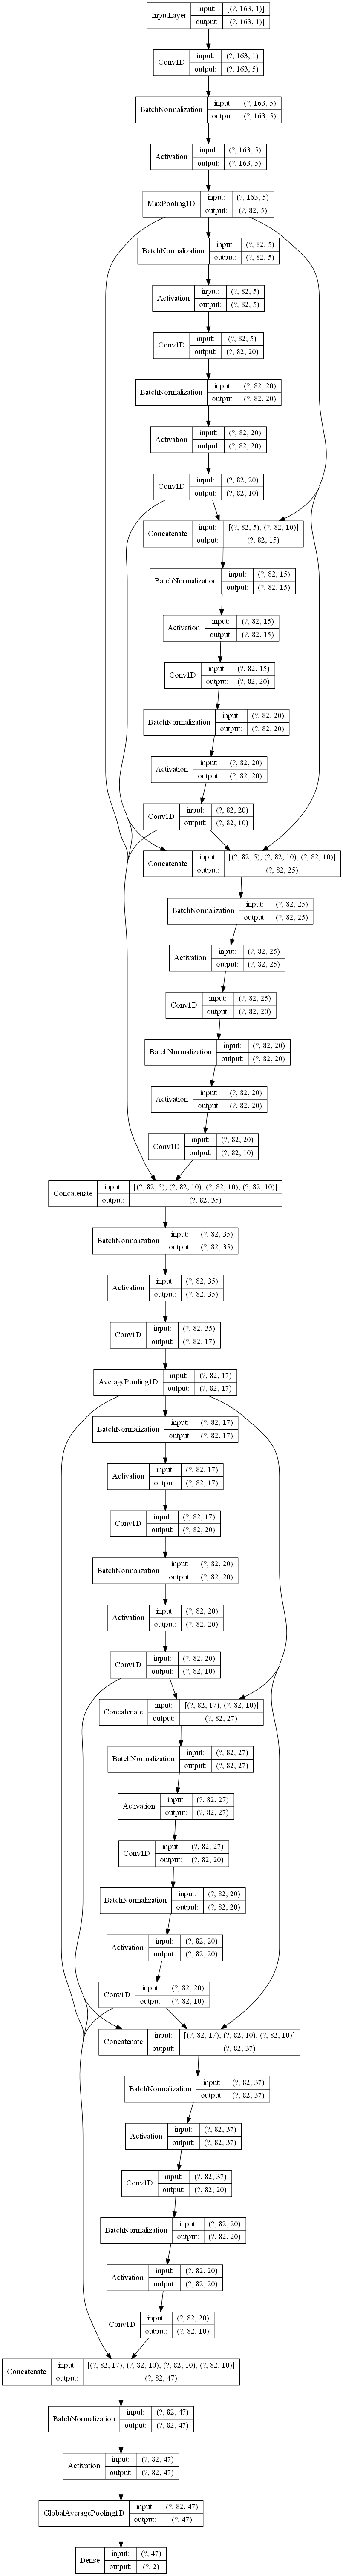

In [47]:
tf.keras.utils.plot_model(model_dense, to_file='model_dense_3_2.png', 
                          show_shapes=True, show_layer_names=False, rankdir='TB')

In [48]:
# здесь батчсайз и class_w надо указывать тот, который получился по гридсерч сетке
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.05)

In [ ]:
# anealing - снижение ленингрэйта (на Спайдере не дает доп.эффекта)
#learning_rate=0.005
initial_learning_rate = 0.05

def lr_step_decay(epoch, lr):
    drop_rate = 0.2
    epochs_drop = 20.0
    
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [49]:
VERBOSE = 2 # формат вывода логов обучения
BATCH_SIZE = 512
NB_EPOCH = 200 # максимальное количество эпох, если не отработает EarlyStopping
class_weighting = {0:0.05 , 1:1} #{0:0.00163 , 1:1} можно подбирать как гипер.параметр.

with tf.device('/GPU:0'):
    history_logs = model_dense.fit_generator(generator=training_generator,
                    validation_data= (X_2_2, Y_test_2) , #validation_generator,
                   #use_multiprocessing=True, 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)])
                                       #, LearningRateScheduler(lr_step_decay, verbose=1)])

Instructions for updating:
Please use Model.fit, which supports generators.
train_begin | time:  22.03.2021 13:39:33
Epoch 1/200
epoch_end | time:  22.03.2021 14:25:19
2945/2945 - 2742s - loss: 0.0089 - accuracy: 0.9707 - auc_9: 0.9952 - precision_9: 0.9707 - recall_9: 0.9707 - val_loss: 0.0237 - val_accuracy: 0.9948 - val_auc_9: 0.9994 - val_precision_9: 0.9948 - val_recall_9: 0.9948
Epoch 2/200
epoch_end | time:  22.03.2021 15:10:55
2945/2945 - 2735s - loss: 0.0062 - accuracy: 0.9834 - auc_9: 0.9978 - precision_9: 0.9834 - recall_9: 0.9834 - val_loss: 0.0614 - val_accuracy: 0.9821 - val_auc_9: 0.9970 - val_precision_9: 0.9821 - val_recall_9: 0.9821
Epoch 3/200
epoch_end | time:  22.03.2021 15:56:37
2945/2945 - 2742s - loss: 0.0057 - accuracy: 0.9852 - auc_9: 0.9982 - precision_9: 0.9852 - recall_9: 0.9852 - val_loss: 0.1196 - val_accuracy: 0.9603 - val_auc_9: 0.9900 - val_precision_9: 0.9603 - val_recall_9: 0.9603
Epoch 4/200
epoch_end | time:  22.03.2021 16:41:53
2945/2945 - 2715s -

Epoch 31/200
epoch_end | time:  23.03.2021 20:30:12
2945/2945 - 3177s - loss: 0.0034 - accuracy: 0.9893 - auc_9: 0.9993 - precision_9: 0.9893 - recall_9: 0.9893 - val_loss: 0.0188 - val_accuracy: 0.9952 - val_auc_9: 0.9993 - val_precision_9: 0.9952 - val_recall_9: 0.9952
Epoch 32/200
epoch_end | time:  23.03.2021 21:22:25
2945/2945 - 3132s - loss: 0.0033 - accuracy: 0.9894 - auc_9: 0.9993 - precision_9: 0.9894 - recall_9: 0.9894 - val_loss: 0.0214 - val_accuracy: 0.9945 - val_auc_9: 0.9991 - val_precision_9: 0.9945 - val_recall_9: 0.9945
Epoch 33/200
epoch_end | time:  23.03.2021 22:15:15
2945/2945 - 3168s - loss: 0.0033 - accuracy: 0.9894 - auc_9: 0.9993 - precision_9: 0.9894 - recall_9: 0.9894 - val_loss: 0.0206 - val_accuracy: 0.9950 - val_auc_9: 0.9992 - val_precision_9: 0.9950 - val_recall_9: 0.9950
Epoch 34/200
epoch_end | time:  23.03.2021 23:07:20
2945/2945 - 3124s - loss: 0.0033 - accuracy: 0.9895 - auc_9: 0.9993 - precision_9: 0.9895 - recall_9: 0.9895 - val_loss: 0.0220 - va

In [50]:
res_model_dense_3_3 = pd.DataFrame(history_logs.history, columns = history_logs.history.keys())
model_dense.save('model_dense_3_3' + '.h5')
res_model_dense_3_3.to_csv('model_dense_3_3' + '.csv')

In [51]:
predict_class_val = model_dense.predict(X_2_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.04985971030765286, 0.914258992348814, 0.828517984697628)

In [52]:
predict_class_val = model_dense.predict(X_3_2)
APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.050265644441230946, 0.9037704859602441, 0.8075409719204882)

### GridSearch for DenseNet-8

In [65]:
# Гридсерч сетку настроить:
# k = {5, 10}
# initial_filters = {5, 10}, # количество фильтров лучше взять 5-10-20 (64 - из 2D)
# block_sizes = [3, 3] - для Spider-6; [4, 4] - для Spider-8
# conv_kernel_width = w, где for w in [5, 6] 
# bottleneck_size=2, лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
# transition_pool_size=2,
# transition_pool_stride=2, # здесь лучше поставить страйд = 1 (2 - из 2D)
# theta=0.5, # это параметр для баттлнек сверток 1х1, настроить парочку из списка: {0.4, 0.5, 0.6, 1}
# initial_conv_width=5,  # здесь лучше поставить 5 (7 - для 2D)
# initial_stride=2, # здесь лучше 1 взять (2 - из 2D)
# initial_pool_width=3, # этот пулинг лучше 2 взять (3 - из 2D)
# initial_pool_stride=2  # здесь лучше поставить страйд = 1, а то размерность будет быстро уменьшаться


n_features = 163

for k_i in [5, 10]:
    for theta_i in [0.5, 1]:
        for w in [3, 5]:
            if ((k_i != 5) or (theta_i != 0.5) or (w != 5)):
                if True: #((k_i != 10) or (theta_i != 1) or (w != 3)):
                    model_dense = DenseNetCustom(input_shape = (163, 1),
                                                 num_outputs=2,
                                                 block_sizes= [3, 3],
                                                 initial_filters=5,
                                                 k=k_i, 
                                                 conv_kernel_width=5,
                                                 bottleneck_size=2,
                                                 transition_pool_stride=1,
                                                 theta=theta_i,
                                                 initial_conv_width=w,
                                                 initial_stride=1,
                                                 initial_pool_width=2,
                                                 initial_pool_stride=2)

                    model_dense.compile(loss='categorical_crossentropy',
                                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                                        metrics=['accuracy', tf.keras.metrics.AUC(),
                                                 tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

                    VERBOSE = 2 # формат вывода логов обучения
                    BATCH_SIZE = 512
                    NB_EPOCH = 100 # максимальное количество эпох, если не отработает EarlyStopping
                    class_weighting = {0:0.05 , 1:1} #{0:0.00163 , 1:1} можно подбирать как гипер.параметр.

                    history_logs = model_dense.fit_generator(generator=training_generator,
                                                             validation_data= (X_2_2, Y_test_2),
                                                             epochs=NB_EPOCH, verbose=VERBOSE,
                                                             class_weight=class_weighting,
                                                             callbacks=[_time, EarlyStopping(monitor='val_loss', patience=15)])

                    res_model_dense_3_3 = pd.DataFrame(history_logs.history, columns = history_logs.history.keys())
                    model_dense.save('model_dense_c3c3' + '_k' + str(k_i) + '_t' + str(theta_i) + '_w' + str(w) + '.h5')
                    res_model_dense_3_3.to_csv('model_dense_c3c3' + '_k' + str(k_i) + '_t' + str(theta_i) + '_w' + str(w) + '.csv')

                    predict_class_val = model_dense.predict(X_2_2)
                    APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
                    AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
                    GINI = 2*AUC - 1
                    print('VALIDATION:', 'APS:', APS, 'AUC_ROC:', AUC, 'GINI:', GINI)

                    predict_class_val = model_dense.predict(X_3_2)
                    APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
                    AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
                    GINI = 2*AUC - 1
                    print('TEST:', 'APS:', APS, 'AUC_ROC:', AUC, 'GINI:', GINI)



train_begin | time:  26.03.2021 17:05:45
Epoch 1/100
epoch_end | time:  26.03.2021 17:32:47
2945/2945 - 1617s - loss: 0.0110 - accuracy: 0.9593 - auc_13: 0.9920 - precision_13: 0.9593 - recall_13: 0.9593 - val_loss: 0.1493 - val_accuracy: 0.9454 - val_auc_13: 0.9855 - val_precision_13: 0.9454 - val_recall_13: 0.9454
Epoch 2/100
epoch_end | time:  26.03.2021 18:00:08
2945/2945 - 1640s - loss: 0.0079 - accuracy: 0.9748 - auc_13: 0.9962 - precision_13: 0.9748 - recall_13: 0.9748 - val_loss: 0.0637 - val_accuracy: 0.9789 - val_auc_13: 0.9974 - val_precision_13: 0.9789 - val_recall_13: 0.9789
Epoch 3/100
epoch_end | time:  26.03.2021 18:27:52
2945/2945 - 1663s - loss: 0.0070 - accuracy: 0.9792 - auc_13: 0.9972 - precision_13: 0.9792 - recall_13: 0.9792 - val_loss: 0.0249 - val_accuracy: 0.9933 - val_auc_13: 0.9990 - val_precision_13: 0.9933 - val_recall_13: 0.9933
Epoch 4/100
epoch_end | time:  26.03.2021 18:55:33
2945/2945 - 1661s - loss: 0.0065 - accuracy: 0.9818 - auc_13: 0.9976 - precis

Epoch 31/100
epoch_end | time:  27.03.2021 07:13:21
2945/2945 - 1606s - loss: 0.0046 - accuracy: 0.9876 - auc_13: 0.9989 - precision_13: 0.9876 - recall_13: 0.9876 - val_loss: 0.0286 - val_accuracy: 0.9931 - val_auc_13: 0.9994 - val_precision_13: 0.9931 - val_recall_13: 0.9931
Epoch 32/100
epoch_end | time:  27.03.2021 07:40:10
2945/2945 - 1609s - loss: 0.0046 - accuracy: 0.9877 - auc_13: 0.9989 - precision_13: 0.9877 - recall_13: 0.9877 - val_loss: 0.0368 - val_accuracy: 0.9898 - val_auc_13: 0.9988 - val_precision_13: 0.9898 - val_recall_13: 0.9898
Epoch 33/100
epoch_end | time:  27.03.2021 08:06:57
2945/2945 - 1606s - loss: 0.0045 - accuracy: 0.9878 - auc_13: 0.9990 - precision_13: 0.9878 - recall_13: 0.9878 - val_loss: 0.0497 - val_accuracy: 0.9849 - val_auc_13: 0.9984 - val_precision_13: 0.9849 - val_recall_13: 0.9849
Epoch 34/100
epoch_end | time:  27.03.2021 08:33:42
2945/2945 - 1604s - loss: 0.0045 - accuracy: 0.9875 - auc_13: 0.9989 - precision_13: 0.9875 - recall_13: 0.9875 - 

Epoch 11/100
epoch_end | time:  27.03.2021 21:14:22
2945/2945 - 1922s - loss: 0.0052 - accuracy: 0.9858 - auc_14: 0.9986 - precision_14: 0.9858 - recall_14: 0.9858 - val_loss: 0.0238 - val_accuracy: 0.9946 - val_auc_14: 0.9994 - val_precision_14: 0.9946 - val_recall_14: 0.9946
Epoch 12/100
epoch_end | time:  27.03.2021 21:46:22
2945/2945 - 1920s - loss: 0.0051 - accuracy: 0.9860 - auc_14: 0.9986 - precision_14: 0.9860 - recall_14: 0.9860 - val_loss: 0.0339 - val_accuracy: 0.9916 - val_auc_14: 0.9992 - val_precision_14: 0.9916 - val_recall_14: 0.9916
Epoch 13/100
epoch_end | time:  27.03.2021 22:25:03
2945/2945 - 2320s - loss: 0.0051 - accuracy: 0.9860 - auc_14: 0.9986 - precision_14: 0.9860 - recall_14: 0.9860 - val_loss: 0.0362 - val_accuracy: 0.9905 - val_auc_14: 0.9987 - val_precision_14: 0.9905 - val_recall_14: 0.9905
Epoch 14/100
epoch_end | time:  27.03.2021 23:06:57
2945/2945 - 2513s - loss: 0.0050 - accuracy: 0.9863 - auc_14: 0.9987 - precision_14: 0.9863 - recall_14: 0.9863 - 

Epoch 8/100
epoch_end | time:  28.03.2021 17:45:11
2945/2945 - 2605s - loss: 0.0055 - accuracy: 0.9855 - auc_15: 0.9984 - precision_15: 0.9855 - recall_15: 0.9855 - val_loss: 0.0479 - val_accuracy: 0.9845 - val_auc_15: 0.9981 - val_precision_15: 0.9845 - val_recall_15: 0.9845
Epoch 9/100
epoch_end | time:  28.03.2021 18:28:31
2945/2945 - 2600s - loss: 0.0054 - accuracy: 0.9856 - auc_15: 0.9985 - precision_15: 0.9856 - recall_15: 0.9856 - val_loss: 0.0347 - val_accuracy: 0.9911 - val_auc_15: 0.9991 - val_precision_15: 0.9911 - val_recall_15: 0.9911
Epoch 10/100
epoch_end | time:  28.03.2021 19:11:45
2945/2945 - 2592s - loss: 0.0053 - accuracy: 0.9860 - auc_15: 0.9985 - precision_15: 0.9860 - recall_15: 0.9860 - val_loss: 0.0422 - val_accuracy: 0.9880 - val_auc_15: 0.9986 - val_precision_15: 0.9880 - val_recall_15: 0.9880
Epoch 11/100
epoch_end | time:  28.03.2021 19:54:58
2945/2945 - 2592s - loss: 0.0052 - accuracy: 0.9861 - auc_15: 0.9986 - precision_15: 0.9861 - recall_15: 0.9861 - va

Epoch 9/100
epoch_end | time:  29.03.2021 15:12:02
2945/2945 - 3771s - loss: 0.0046 - accuracy: 0.9875 - auc_16: 0.9988 - precision_16: 0.9875 - recall_16: 0.9875 - val_loss: 0.0316 - val_accuracy: 0.9926 - val_auc_16: 0.9994 - val_precision_16: 0.9926 - val_recall_16: 0.9926
Epoch 10/100
epoch_end | time:  29.03.2021 16:22:45
2945/2945 - 4242s - loss: 0.0045 - accuracy: 0.9876 - auc_16: 0.9989 - precision_16: 0.9876 - recall_16: 0.9876 - val_loss: 0.0323 - val_accuracy: 0.9905 - val_auc_16: 0.9993 - val_precision_16: 0.9905 - val_recall_16: 0.9905
Epoch 11/100
epoch_end | time:  29.03.2021 17:34:08
2945/2945 - 4281s - loss: 0.0044 - accuracy: 0.9878 - auc_16: 0.9989 - precision_16: 0.9878 - recall_16: 0.9878 - val_loss: 0.0507 - val_accuracy: 0.9836 - val_auc_16: 0.9985 - val_precision_16: 0.9836 - val_recall_16: 0.9836
Epoch 12/100
epoch_end | time:  29.03.2021 18:49:36
2945/2945 - 4527s - loss: 0.0044 - accuracy: 0.9877 - auc_16: 0.9989 - precision_16: 0.9877 - recall_16: 0.9877 - v

Epoch 17/100
epoch_end | time:  31.03.2021 04:05:38
2945/2945 - 4553s - loss: 0.0041 - accuracy: 0.9880 - auc_17: 0.9990 - precision_17: 0.9880 - recall_17: 0.9880 - val_loss: 0.0266 - val_accuracy: 0.9935 - val_auc_17: 0.9993 - val_precision_17: 0.9935 - val_recall_17: 0.9935
Epoch 18/100
epoch_end | time:  31.03.2021 05:07:14
2945/2945 - 3694s - loss: 0.0040 - accuracy: 0.9883 - auc_17: 0.9991 - precision_17: 0.9883 - recall_17: 0.9883 - val_loss: 0.0555 - val_accuracy: 0.9808 - val_auc_17: 0.9979 - val_precision_17: 0.9808 - val_recall_17: 0.9808
Epoch 19/100
epoch_end | time:  31.03.2021 06:08:13
2945/2945 - 3658s - loss: 0.0039 - accuracy: 0.9884 - auc_17: 0.9991 - precision_17: 0.9884 - recall_17: 0.9884 - val_loss: 0.0257 - val_accuracy: 0.9931 - val_auc_17: 0.9994 - val_precision_17: 0.9931 - val_recall_17: 0.9931
Epoch 20/100
epoch_end | time:  31.03.2021 07:06:43
2945/2945 - 3509s - loss: 0.0039 - accuracy: 0.9884 - auc_17: 0.9991 - precision_17: 0.9884 - recall_17: 0.9884 - 

Epoch 21/100
epoch_end | time:  01.04.2021 17:19:23
2945/2945 - 4872s - loss: 0.0036 - accuracy: 0.9889 - auc_18: 0.9992 - precision_18: 0.9889 - recall_18: 0.9889 - val_loss: 0.0183 - val_accuracy: 0.9957 - val_auc_18: 0.9994 - val_precision_18: 0.9957 - val_recall_18: 0.9957
Epoch 22/100
epoch_end | time:  01.04.2021 18:38:30
2945/2945 - 4745s - loss: 0.0036 - accuracy: 0.9891 - auc_18: 0.9992 - precision_18: 0.9891 - recall_18: 0.9891 - val_loss: 0.0231 - val_accuracy: 0.9938 - val_auc_18: 0.9993 - val_precision_18: 0.9938 - val_recall_18: 0.9938
Epoch 23/100
epoch_end | time:  01.04.2021 19:54:03
2945/2945 - 4531s - loss: 0.0035 - accuracy: 0.9892 - auc_18: 0.9992 - precision_18: 0.9892 - recall_18: 0.9892 - val_loss: 0.0220 - val_accuracy: 0.9944 - val_auc_18: 0.9993 - val_precision_18: 0.9944 - val_recall_18: 0.9944
Epoch 24/100
epoch_end | time:  01.04.2021 21:05:10
2945/2945 - 4266s - loss: 0.0035 - accuracy: 0.9891 - auc_18: 0.9992 - precision_18: 0.9891 - recall_18: 0.9891 - 

Epoch 14/100
epoch_end | time:  03.04.2021 04:34:56
2945/2945 - 4019s - loss: 0.0041 - accuracy: 0.9883 - auc_19: 0.9990 - precision_19: 0.9883 - recall_19: 0.9883 - val_loss: 0.0467 - val_accuracy: 0.9868 - val_auc_19: 0.9984 - val_precision_19: 0.9868 - val_recall_19: 0.9868
Epoch 15/100
epoch_end | time:  03.04.2021 05:36:18
2945/2945 - 3681s - loss: 0.0041 - accuracy: 0.9884 - auc_19: 0.9990 - precision_19: 0.9884 - recall_19: 0.9884 - val_loss: 0.0230 - val_accuracy: 0.9952 - val_auc_19: 0.9994 - val_precision_19: 0.9952 - val_recall_19: 0.9952
Epoch 16/100
epoch_end | time:  03.04.2021 06:37:44
2945/2945 - 3685s - loss: 0.0040 - accuracy: 0.9884 - auc_19: 0.9991 - precision_19: 0.9884 - recall_19: 0.9884 - val_loss: 0.1090 - val_accuracy: 0.9649 - val_auc_19: 0.9913 - val_precision_19: 0.9649 - val_recall_19: 0.9649
Epoch 17/100
epoch_end | time:  03.04.2021 07:38:53
2945/2945 - 3668s - loss: 0.0039 - accuracy: 0.9887 - auc_19: 0.9991 - precision_19: 0.9887 - recall_19: 0.9887 - 

Epoch 44/100
epoch_end | time:  04.04.2021 11:15:41
2945/2945 - 3680s - loss: 0.0027 - accuracy: 0.9907 - auc_19: 0.9994 - precision_19: 0.9907 - recall_19: 0.9907 - val_loss: 0.0263 - val_accuracy: 0.9926 - val_auc_19: 0.9988 - val_precision_19: 0.9926 - val_recall_19: 0.9926
Epoch 45/100
epoch_end | time:  04.04.2021 12:17:19
2945/2945 - 3697s - loss: 0.0027 - accuracy: 0.9907 - auc_19: 0.9994 - precision_19: 0.9907 - recall_19: 0.9907 - val_loss: 0.0202 - val_accuracy: 0.9950 - val_auc_19: 0.9990 - val_precision_19: 0.9950 - val_recall_19: 0.9950
Epoch 46/100
epoch_end | time:  04.04.2021 13:18:52
2945/2945 - 3691s - loss: 0.0027 - accuracy: 0.9906 - auc_19: 0.9994 - precision_19: 0.9906 - recall_19: 0.9906 - val_loss: 0.0254 - val_accuracy: 0.9923 - val_auc_19: 0.9990 - val_precision_19: 0.9923 - val_recall_19: 0.9923
Epoch 47/100
epoch_end | time:  04.04.2021 14:20:18
2945/2945 - 3685s - loss: 0.0026 - accuracy: 0.9909 - auc_19: 0.9994 - precision_19: 0.9909 - recall_19: 0.9909 - 

In [62]:
for k_i in [5, 10]:
    for theta_i in [0.5, 1]:
        for w in [3, 5]:
            if ((k_i != 5) or (theta_i != 0.5) or (w != 5)):
                if ((k_i != 10) or (theta_i != 1) or (w != 3)):
                    print('k=', k_i, 't=', theta_i, 'w=', w)

k= 5 t= 0.5 w= 3
k= 5 t= 1 w= 3
k= 5 t= 1 w= 5
k= 10 t= 0.5 w= 3
k= 10 t= 0.5 w= 5
k= 10 t= 1 w= 5


In [66]:
for k_i in [5, 10]:
    for theta_i in [0.5, 1]:
        for w in [3, 5]:
            if ((k_i != 5) or (theta_i != 0.5) or (w != 5)):
                print('k=', k_i, 't=', theta_i, 'w=', w)

k= 5 t= 0.5 w= 3
k= 5 t= 1 w= 3
k= 5 t= 1 w= 5
k= 10 t= 0.5 w= 3
k= 10 t= 0.5 w= 5
k= 10 t= 1 w= 3
k= 10 t= 1 w= 5


In [67]:
for k_i in [10, 15]:
    for theta_i in [0.5]:
        for w in [5, 7]:
            if ((k_i != 10) or (theta_i != 0.5) or (w != 5)):
                if True: #((k_i != 10) or (theta_i != 1) or (w != 3)):
                    print('k=', k_i, 't=', theta_i, 'w=', w)

k= 10 t= 0.5 w= 7
k= 15 t= 0.5 w= 5
k= 15 t= 0.5 w= 7


In [68]:
##### Дополнительный ГридСерч

# Гридсерч сетку настроить:
# k = {5, 10}
# initial_filters = {5, 10}, # количество фильтров лучше взять 5-10-20 (64 - из 2D)
# block_sizes = [3, 3] - для Spider-6; [4, 4] - для Spider-8
# conv_kernel_width = w, где for w in [5, 6] 
# bottleneck_size=2, лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
# transition_pool_size=2,
# transition_pool_stride=2, # здесь лучше поставить страйд = 1 (2 - из 2D)
# theta=0.5, # это параметр для баттлнек сверток 1х1, настроить парочку из списка: {0.4, 0.5, 0.6, 1}
# initial_conv_width=5,  # здесь лучше поставить 5 (7 - для 2D)
# initial_stride=2, # здесь лучше 1 взять (2 - из 2D)
# initial_pool_width=3, # этот пулинг лучше 2 взять (3 - из 2D)
# initial_pool_stride=2  # здесь лучше поставить страйд = 1, а то размерность будет быстро уменьшаться


n_features = 163



for k_i in [10, 15]:
    for theta_i in [0.5]:
        for w in [5, 7]:
            if ((k_i != 10) or (theta_i != 0.5) or (w != 5)):
                if True: #((k_i != 10) or (theta_i != 1) or (w != 3)):
                    model_dense = DenseNetCustom(input_shape = (163, 1),
                                                 num_outputs=2,
                                                 block_sizes= [3, 3],
                                                 initial_filters=5,
                                                 k=k_i, 
                                                 conv_kernel_width=5,
                                                 bottleneck_size=2,
                                                 transition_pool_stride=1,
                                                 theta=theta_i,
                                                 initial_conv_width=w,
                                                 initial_stride=1,
                                                 initial_pool_width=2,
                                                 initial_pool_stride=2)

                    model_dense.compile(loss='categorical_crossentropy',
                                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                                        metrics=['accuracy', tf.keras.metrics.AUC(),
                                                 tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

                    VERBOSE = 2 # формат вывода логов обучения
                    BATCH_SIZE = 512
                    NB_EPOCH = 100 # максимальное количество эпох, если не отработает EarlyStopping
                    class_weighting = {0:0.05 , 1:1} #{0:0.00163 , 1:1} можно подбирать как гипер.параметр.

                    history_logs = model_dense.fit_generator(generator=training_generator,
                                                             validation_data= (X_2_2, Y_test_2),
                                                             epochs=NB_EPOCH, verbose=VERBOSE,
                                                             class_weight=class_weighting,
                                                             callbacks=[_time, EarlyStopping(monitor='val_loss', patience=15)])

                    res_model_dense_3_3 = pd.DataFrame(history_logs.history, columns = history_logs.history.keys())
                    model_dense.save('model_dense_c3c3' + '_k' + str(k_i) + '_t' + str(theta_i) + '_w' + str(w) + '.h5')
                    res_model_dense_3_3.to_csv('model_dense_c3c3' + '_k' + str(k_i) + '_t' + str(theta_i) + '_w' + str(w) + '.csv')

                    predict_class_val = model_dense.predict(X_2_2)
                    APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
                    AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
                    GINI = 2*AUC - 1
                    print('=========================================')
                    print('VALIDATION:', 'APS:', APS, 'AUC_ROC:', AUC, 'GINI:', GINI)

                    predict_class_val = model_dense.predict(X_3_2)
                    APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
                    AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
                    GINI = 2*AUC - 1
                    print('TEST:', 'APS:', APS, 'AUC_ROC:', AUC, 'GINI:', GINI)
                    print('=========================================')
                    print('')
                    



train_begin | time:  05.04.2021 20:34:00
Epoch 1/100
epoch_end | time:  05.04.2021 21:32:47
2945/2945 - 3521s - loss: 0.0090 - accuracy: 0.9700 - auc_20: 0.9952 - precision_20: 0.9700 - recall_20: 0.9700 - val_loss: 0.0597 - val_accuracy: 0.9789 - val_auc_20: 0.9978 - val_precision_20: 0.9789 - val_recall_20: 0.9789
Epoch 2/100
epoch_end | time:  05.04.2021 22:29:00
2945/2945 - 3372s - loss: 0.0064 - accuracy: 0.9818 - auc_20: 0.9978 - precision_20: 0.9818 - recall_20: 0.9818 - val_loss: 0.1502 - val_accuracy: 0.9456 - val_auc_20: 0.9852 - val_precision_20: 0.9456 - val_recall_20: 0.9456
Epoch 3/100
epoch_end | time:  05.04.2021 23:23:57
2945/2945 - 3296s - loss: 0.0059 - accuracy: 0.9838 - auc_20: 0.9981 - precision_20: 0.9838 - recall_20: 0.9838 - val_loss: 0.1819 - val_accuracy: 0.9327 - val_auc_20: 0.9790 - val_precision_20: 0.9327 - val_recall_20: 0.9327
Epoch 4/100
epoch_end | time:  06.04.2021 00:18:30
2945/2945 - 3272s - loss: 0.0056 - accuracy: 0.9849 - auc_20: 0.9983 - precis

Epoch 31/100
epoch_end | time:  07.04.2021 01:33:25
2945/2945 - 3318s - loss: 0.0035 - accuracy: 0.9890 - auc_20: 0.9992 - precision_20: 0.9890 - recall_20: 0.9890 - val_loss: 0.0203 - val_accuracy: 0.9949 - val_auc_20: 0.9993 - val_precision_20: 0.9949 - val_recall_20: 0.9949
Epoch 32/100
epoch_end | time:  07.04.2021 02:28:48
2945/2945 - 3322s - loss: 0.0034 - accuracy: 0.9892 - auc_20: 0.9992 - precision_20: 0.9892 - recall_20: 0.9892 - val_loss: 0.0333 - val_accuracy: 0.9907 - val_auc_20: 0.9991 - val_precision_20: 0.9907 - val_recall_20: 0.9907
VALIDATION: APS: 0.05275438900597422 AUC_ROC: 0.92122279241821 GINI: 0.8424455848364201
TEST: APS: 0.04582367976578686 AUC_ROC: 0.9230978249094874 GINI: 0.8461956498189749

train_begin | time:  07.04.2021 02:30:21
Epoch 1/100
epoch_end | time:  07.04.2021 03:50:35
2945/2945 - 4809s - loss: 0.0083 - accuracy: 0.9733 - auc_21: 0.9959 - precision_21: 0.9733 - recall_21: 0.9733 - val_loss: 0.0480 - val_accuracy: 0.9849 - val_auc_21: 0.9982 - va

Epoch 28/100
epoch_end | time:  08.04.2021 16:36:14
2945/2945 - 3980s - loss: 0.0027 - accuracy: 0.9906 - auc_21: 0.9994 - precision_21: 0.9906 - recall_21: 0.9906 - val_loss: 0.0238 - val_accuracy: 0.9933 - val_auc_21: 0.9992 - val_precision_21: 0.9933 - val_recall_21: 0.9933
Epoch 29/100
epoch_end | time:  08.04.2021 17:44:59
2945/2945 - 4124s - loss: 0.0027 - accuracy: 0.9907 - auc_21: 0.9994 - precision_21: 0.9907 - recall_21: 0.9907 - val_loss: 0.0258 - val_accuracy: 0.9926 - val_auc_21: 0.9989 - val_precision_21: 0.9926 - val_recall_21: 0.9926
Epoch 30/100
epoch_end | time:  08.04.2021 19:06:37
2945/2945 - 4896s - loss: 0.0026 - accuracy: 0.9908 - auc_21: 0.9994 - precision_21: 0.9908 - recall_21: 0.9908 - val_loss: 0.0198 - val_accuracy: 0.9949 - val_auc_21: 0.9990 - val_precision_21: 0.9949 - val_recall_21: 0.9949
Epoch 31/100
epoch_end | time:  08.04.2021 20:43:13
2945/2945 - 5794s - loss: 0.0026 - accuracy: 0.9910 - auc_21: 0.9994 - precision_21: 0.9910 - recall_21: 0.9910 - 

Epoch 10/100
epoch_end | time:  10.04.2021 04:58:24
2945/2945 - 4112s - loss: 0.0042 - accuracy: 0.9882 - auc_22: 0.9990 - precision_22: 0.9882 - recall_22: 0.9882 - val_loss: 0.0295 - val_accuracy: 0.9918 - val_auc_22: 0.9991 - val_precision_22: 0.9918 - val_recall_22: 0.9918
Epoch 11/100
epoch_end | time:  10.04.2021 06:07:06
2945/2945 - 4120s - loss: 0.0040 - accuracy: 0.9885 - auc_22: 0.9990 - precision_22: 0.9885 - recall_22: 0.9885 - val_loss: 0.0204 - val_accuracy: 0.9949 - val_auc_22: 0.9992 - val_precision_22: 0.9949 - val_recall_22: 0.9949
Epoch 12/100
epoch_end | time:  10.04.2021 07:15:47
2945/2945 - 4120s - loss: 0.0039 - accuracy: 0.9886 - auc_22: 0.9991 - precision_22: 0.9886 - recall_22: 0.9886 - val_loss: 0.0221 - val_accuracy: 0.9943 - val_auc_22: 0.9993 - val_precision_22: 0.9943 - val_recall_22: 0.9943
Epoch 13/100
epoch_end | time:  10.04.2021 08:22:43
2945/2945 - 4015s - loss: 0.0039 - accuracy: 0.9888 - auc_22: 0.9991 - precision_22: 0.9888 - recall_22: 0.9888 - 

In [ ]:
result_all = pd.DataFrame()
result_all['name_model'] = None
result_all['params'] = None
result_all['val_GINI'] = None
result_all['val_APS'] = None
result_all['test_GINI'] = None
result_all['test_APS'] = None
j = 0

for p in param:
    
    model_grid = spider_model(gl_pool_max = p[0], reg = p[1],
                             n_kernel = p[2], n_filters = p[3], hidden = p[4])
    model_grid.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    history_XX = model_grid.fit_generator(generator=training_generator,  #training_aug,
                    validation_data= (X_2_2, Y_test_2) , 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)
                                       , LearningRateScheduler(lr_step_decay, verbose=1)])
    
    res_model_ = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
    name_m = 'model_spider6_grid' + str(p[0]) + '_' + str(p[1]) + '_' + str(p[2]) + '_' + str(p[3]) + '_' + str(p[4])
    model_grid.save( name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')
    
    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
    GINI = 2*(metrics.roc_auc_score(y_test, predict_class_val[:,1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_val, predict_class_test[:,1])
    GINI_t = 2*(metrics.roc_auc_score(y_val, predict_class_test[:,1])) - 1
    
    result_all.at[j , 'name_model'] = name_m
    result_all.at[j ,'params'] = str(p)
    result_all.at[j ,'val_GINI'] = GINI
    result_all.at[j ,'val_APS'] = APS
    result_all.at[j ,'test_GINI'] = GINI_t
    result_all.at[j ,'test_APS'] = APS_t
    j += 1
    print(name_m, 'test: ', GINI, APS, '| val: ', GINI_t, APS_t)
    



In [70]:
for k_i in [10, 15]:
    for theta_i in [0.5]:
        for w in [5, 7]:
            if ((k_i != 10) or (theta_i != 0.5) or (w != 5)):
                print('k=', k_i, 't=', theta_i, 'w=', w)
                

k= 10 t= 0.5 w= 7
k= 15 t= 0.5 w= 5
k= 15 t= 0.5 w= 7
